In [1]:
%matplotlib inline

import numpy as np
import os
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from PIL import Image
import math
import importlib
import helper


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


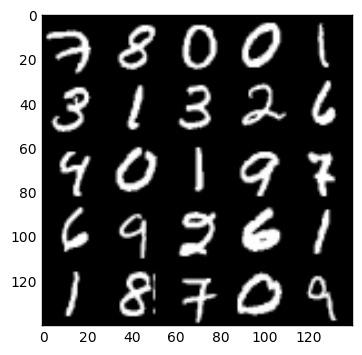

In [3]:
num_img = 25
img = mnist.train.images[:num_img]
img = img.reshape(num_img,28,28,1)

plt.imshow(helper.images_square_grid(img, 'L'), cmap='gray')
#plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [60]:
class SENS_network:
    
    # Train the network
    def __init__(self, epoch_count, batch_size, embedded_image_dim, learning_rate, beta1, img_shape, data_image_mode, logs_path):

        self.embedded_image_dim = embedded_image_dim
        self.img_shape = img_shape
        self.data_image_mode = data_image_mode



        # get tf input variables
        self.input_images_tf, self.target_output_images_tf, self.embedded_image_input_tf, self.learning_rate_tf = sens.model_inputs(img_shape, img_shape, len(data_image_mode), embedded_image_dim)

        # get loss and output variables
        self.autoencoder_cost_tf, self.autoencoder_output_tf, self.discriminator_cost_tf, self.discriminator_output_tf, self.generated_output_tf, self.discriminator_loss_fake, self.discriminator_loss_real, self.generator_cost_tf =  sens.model_loss(self.input_images_tf, len(data_image_mode), self.target_output_images_tf, embedded_image_dim, self.embedded_image_input_tf)
    
         # create model optimizers
        self.autoencoder_optimizer_tf, self.discriminator_optimizer_tf, self.generator_optimizer_tf = sens.model_opt(self.autoencoder_cost_tf, self.discriminator_cost_tf, self.generator_cost_tf, self.learning_rate_tf, beta1)
    
    
def train(SENs, epoch_count, batch_size, embedded_image_dim, learning_rate, beta1, img_shape, data_image_mode, logs_path):
    
    print_every = 100
    show_every = 500
    steps = 0
    
    samples, losses = [], []
    
    tf.summary.scalar('autoencoder_cost', SENs.autoencoder_cost_tf)
    tf.summary.scalar('generator_cost', SENs.generator_cost_tf)
    tf.summary.scalar('discriminator_cost',SENs.discriminator_cost_tf)
    tf.summary.scalar('discriminator_real_cost',SENs.discriminator_loss_real)
    tf.summary.scalar('discriminator_fake_cost',SENs.discriminator_loss_fake)
    
    merged_tf = tf.summary.merge_all()
    
    # saver for the model
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        file_writer = tf.summary.FileWriter(logs_path,sess.graph)
        
        for epoch_i in range(epoch_count):

            for ii in range(mnist.train.num_examples//batch_size):
                
                mnist_images,_ = mnist.train.next_batch(batch_size)
                batch_images,target_images = helper.get_noisy_target_images(mnist_images,img_shape,0.4,len(data_image_mode),augment=True)

                steps += 1
#
                # Run optimizers
                _, autoencoder_training_cost, summary = sess.run([SENs.autoencoder_optimizer_tf,\
                                                                  SENs.autoencoder_cost_tf,\
                                                                  merged_tf],\
                                                        feed_dict={SENs.input_images_tf: batch_images, \
                                                       SENs.target_output_images_tf: target_images, \
                                                       SENs.embedded_image_input_tf: np.clip(np.random.uniform(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                       SENs.learning_rate_tf:learning_rate})
                
                mnist_images,_ = mnist.train.next_batch(batch_size)
                batch_images,target_images = helper.get_noisy_target_images(mnist_images,img_shape,0.4,len(data_image_mode),augment=False)

                
                _, autoencoder_training_cost, summary, _ = sess.run([SENs.autoencoder_optimizer_tf,\
                                                                  SENs.autoencoder_cost_tf,\
                                                                  merged_tf, \
                                                                  SENs.generator_optimizer_tf],\
                                                        feed_dict={SENs.input_images_tf: batch_images, \
                                                       SENs.target_output_images_tf: target_images, \
                                                       SENs.embedded_image_input_tf: np.clip(np.random.uniform(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                       SENs.learning_rate_tf:learning_rate})
                
                mnist_images,_ = mnist.train.next_batch(batch_size)
                batch_images,target_images = helper.get_noisy_target_images(mnist_images,img_shape,0.4,len(data_image_mode),augment=False)

                _, autoencoder_training_cost, summary, _, _ = sess.run([SENs.autoencoder_optimizer_tf,\
                                                                  SENs.autoencoder_cost_tf,\
                                                                  merged_tf, \
                                                                  SENs.discriminator_optimizer_tf, \
                                                                  SENs.generator_optimizer_tf],\
                                                        feed_dict={SENs.input_images_tf: batch_images, \
                                                       SENs.target_output_images_tf: target_images, \
                                                       SENs.embedded_image_input_tf: np.clip(np.random.normal(size=(batch_size,embedded_image_dim)),0.,1.),\
                                                       SENs.learning_rate_tf:learning_rate})
                
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "AE Cost: {:.4f}".format(autoencoder_training_cost),
                          "")
                    
                    file_writer.add_summary(summary,steps)
                    # Save losses to view after training
                    losses.append((autoencoder_training_cost))
                    
                if steps % show_every == 0:
                    mnist_images,_ = mnist.train.next_batch(25)
                    helper.show_autoencoder_output(sess, SENs.img_shape, mnist_images,SENs.input_images_tf, SENs.autoencoder_output_tf, SENs.generated_output_tf, SENs.embedded_image_input_tf, embedded_image_dim,  data_image_mode,label='pics/'+logs_path[10:])
                    saver.save(sess, "checkpoints/SENS_mnist.ckpt")
              
#                 break
#             break
        mnist_images,_ = mnist.train.next_batch(25)
        helper.show_autoencoder_output(sess, SENs.img_shape, mnist_images,SENs.input_images_tf, SENs.autoencoder_output_tf, SENs.generated_output_tf, SENs.embedded_image_input_tf, embedded_image_dim, data_image_mode,label='pics/'+logs_path[10:])
        saver.save(sess, "checkpoints/SENS_mnist.ckpt")
        
    return SENs, saver

Epoch 1/20... AE Cost: 0.0531
Epoch 1/20... AE Cost: 0.0430
Epoch 1/20... AE Cost: 0.0474
Epoch 1/20... AE Cost: 0.0468
Epoch 1/20... AE Cost: 0.0363
max_in =  1.0   max_out =  0.897708
min_in =  0.0   min_out =  1.66435e-15
(140, 140) (140, 140) (140, 140)


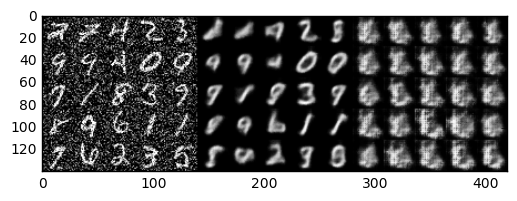

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0431
Epoch 1/20... AE Cost: 0.0409
Epoch 1/20... AE Cost: 0.0441
Epoch 1/20... AE Cost: 0.0382
Epoch 1/20... AE Cost: 0.0501
max_in =  1.0   max_out =  0.922735
min_in =  0.0   min_out =  1.90938e-14
(140, 140) (140, 140) (140, 140)


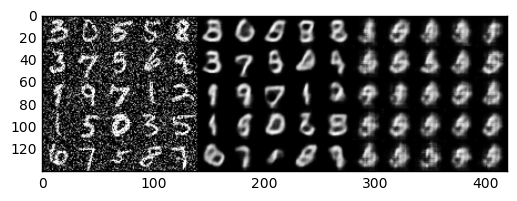

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0278
Epoch 1/20... AE Cost: 0.0550
Epoch 1/20... AE Cost: 0.0431
Epoch 1/20... AE Cost: 0.0363
Epoch 1/20... AE Cost: 0.0405
max_in =  1.0   max_out =  0.977422
min_in =  0.0   min_out =  5.43517e-11
(140, 140) (140, 140) (140, 140)


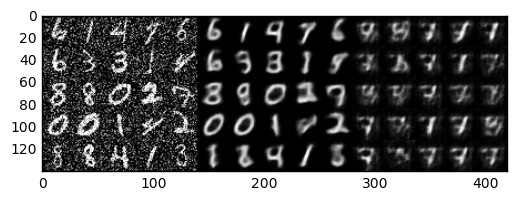

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0357
Epoch 1/20... AE Cost: 0.0422
Epoch 1/20... AE Cost: 0.0335
Epoch 1/20... AE Cost: 0.0309
Epoch 1/20... AE Cost: 0.0378
max_in =  1.0   max_out =  0.941958
min_in =  0.0   min_out =  7.83304e-10
(140, 140) (140, 140) (140, 140)


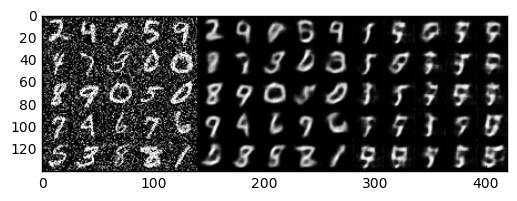

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0416
Epoch 1/20... AE Cost: 0.0457
Epoch 1/20... AE Cost: 0.0364
Epoch 1/20... AE Cost: 0.0436
Epoch 1/20... AE Cost: 0.0392
max_in =  1.0   max_out =  0.957027
min_in =  0.0   min_out =  4.14712e-11
(140, 140) (140, 140) (140, 140)


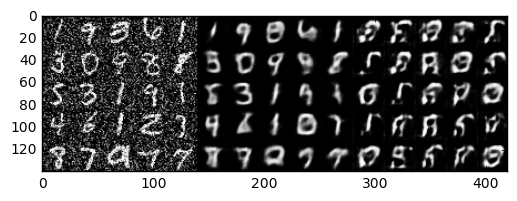

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0440
Epoch 1/20... AE Cost: 0.0373
Epoch 1/20... AE Cost: 0.0384
Epoch 1/20... AE Cost: 0.0317
Epoch 1/20... AE Cost: 0.0354
max_in =  1.0   max_out =  0.989141
min_in =  0.0   min_out =  3.19261e-08
(140, 140) (140, 140) (140, 140)


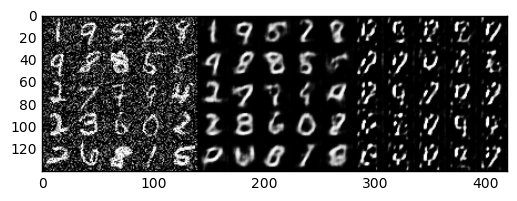

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0303
Epoch 1/20... AE Cost: 0.0332
Epoch 1/20... AE Cost: 0.0247
Epoch 1/20... AE Cost: 0.0402
Epoch 1/20... AE Cost: 0.0271
max_in =  1.0   max_out =  0.981949
min_in =  0.0   min_out =  2.63287e-12
(140, 140) (140, 140) (140, 140)


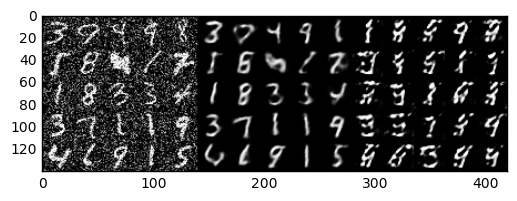

pics/mnist_4_ed_32_lr_0.001
Epoch 1/20... AE Cost: 0.0328
Epoch 1/20... AE Cost: 0.0146
Epoch 1/20... AE Cost: 0.0316
Epoch 1/20... AE Cost: 0.0275
Epoch 1/20... AE Cost: 0.0445
max_in =  1.0   max_out =  0.99464
min_in =  0.0   min_out =  9.52421e-09
(140, 140) (140, 140) (140, 140)


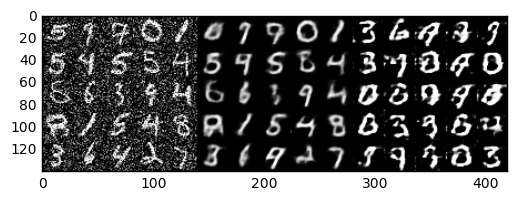

pics/mnist_4_ed_32_lr_0.001


In [ ]:
import sens_network_mnist as sens
import helper_mnist as helper
importlib.reload(sens)
importlib.reload(helper)

batch_size = 4
embedded_image_dim = 32
learning_rate = 0.001
beta1 = 0.4
img_shape = 28
rates = [0.001]
epochs = 20
data_image_mode = 'L'

# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

# for batch_size in [8,16,32]:
#     for embedded_image_dim in [32,64,128]:
#         for learning_rate_i in range(1):

# reset graph
tf.reset_default_graph()

learning_rate = rates[0]
logs_path = './logs/37/'+'mnist_'+str(batch_size)+'_ed_'+str(embedded_image_dim)+'_lr_'+str(learning_rate)

SENs = SENS_network(epochs, batch_size, embedded_image_dim, learning_rate, beta1, img_shape, data_image_mode, logs_path)

SENs, saver = train(SENs, epochs, batch_size, embedded_image_dim, learning_rate, beta1, img_shape, data_image_mode, logs_path)

SENs.default_graph = tf.get_default_graph()

tf.reset_default_graph()



INFO:tensorflow:Restoring parameters from checkpoints/SENS_mnist.ckpt
[1 4 0 6 4 2 2 8 9 5 0 7 1 5 8 2 6 9 6 7 3 2 6 7 1]
(25, 784)
max_in =  1.0   max_out =  0.998266
min_in =  0.0   min_out =  7.31512e-17
(140, 140) (140, 140) (140, 140)


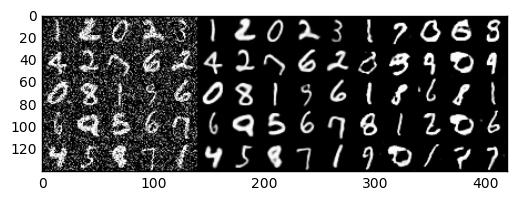

pics/test


In [36]:
importlib.reload(helper)
test_sens(SENs, saver)

In [32]:
def get_SENs(graph,SENs):
    SENs.input_images_tf = graph.get_tensor_by_name('input_images:0')
    SENs.generated_output_tf = graph.get_tensor_by_name('generated_image_output:0')
    SENs.embedded_image_input_tf = graph.get_tensor_by_name('embedded_image_input:0')
    SENs.autoencoder_output_tf = graph.get_tensor_by_name('image_decoder_output:0')
    SENs.image_encoder_output_tf = graph.get_tensor_by_name('image_encoder_output:0')
    
    return SENs

In [25]:
def test_sens(SENs, saver):
    
    loaded_graph = tf.Graph()
    

    with tf.Session(graph=loaded_graph) as sess:
        
        #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
        loader = tf.train.import_meta_graph('checkpoints/SENS_mnist.ckpt.meta')
        loader.restore(sess,'checkpoints/SENS_mnist.ckpt')
        
        SENs = get_SENs(loaded_graph,SENs)
        mnist_images, mnist_labels = mnist.train.next_batch(25)
        print(mnist_labels)
        print(np.shape(mnist_images))
        #print(np.shape(mnist.train.next_batch(25)))
        helper.show_autoencoder_output(sess, SENs.img_shape, mnist_images, SENs.input_images_tf, SENs.autoencoder_output_tf, SENs.generated_output_tf, SENs.embedded_image_input_tf, SENs.embedded_image_dim, SENs.data_image_mode,label='pics/test')



In [55]:
def train_classifier(SENs, batch_size = 500):
    
    loaded_graph = tf.Graph()
    
    

    with tf.Session(graph=loaded_graph) as sess:
        
        

        loader = tf.train.import_meta_graph('checkpoints/SENS_mnist.ckpt.meta')
        loader.restore(sess,'checkpoints/SENS_mnist.ckpt')
        
        SENs = get_SENs(loaded_graph,SENs)
        mnist_images, mnist_labels = mnist.train.next_batch(batch_size)
        mnist_images = np.reshape(mnist_images,(-1,28,28,1))
        
        mnist_test_images, mnist_test_labels = mnist.train.next_batch(batch_size*10)
        mnist_test_images = np.reshape(mnist_test_images,(-1,28,28,1))
        
        encoded_training_images = np.squeeze(sess.run([SENs.image_encoder_output_tf],\
                        feed_dict={SENs.input_images_tf: mnist_images}))
        encoded_test_images = np.squeeze(sess.run([SENs.image_encoder_output_tf],\
                        feed_dict={SENs.input_images_tf: mnist_test_images}))
        
        
    
        
    input_images_tf = tf.placeholder(tf.float32, shape=(None,64),\
        name='input_images')


    targets_tf = tf.placeholder(tf.int32, [None], name='targets')
    target_labels_tf = tf.one_hot(targets_tf, 10)

    with tf.variable_scope('classifier'):
        dense1 = tf.layers.dense(input_images_tf,64,\
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        dense1 = tf.nn.dropout(dense1,0.5)

        dense2 = tf.layers.dense(dense1,64,\
            kernel_initializer=tf.contrib.layers.xavier_initializer())
        dense2 = tf.nn.dropout(dense2,0.5)

        logits = tf.layers.dense(dense2,10,\
            kernel_initializer=tf.contrib.layers.xavier_initializer())

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=target_labels_tf))
        optimizer = tf.train.AdamOptimizer().minimize(cost)

        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(target_labels_tf, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(2000):
        
            _,acc = sess.run([optimizer,accuracy],\
                        feed_dict={input_images_tf: encoded_training_images,\
                                  targets_tf: mnist_labels})
                                         
            
                
            if epoch_i % 100 == 0:
                acc_test = sess.run(accuracy,feed_dict={input_images_tf:encoded_test_images,\
                                                   targets_tf:mnist_test_labels})
                print(acc,acc_test)
             

                
tf.reset_default_graph()
train_classifier(SENs)

INFO:tensorflow:Restoring parameters from checkpoints/SENS_mnist.ckpt
0.092 0.1028
0.696 0.6434
0.798 0.7382
0.862 0.7636
0.89 0.7824
0.902 0.7826
0.894 0.7968
0.932 0.7908
0.924 0.7968
0.932 0.799
0.962 0.81
0.944 0.8002
0.956 0.8086
0.954 0.8072
0.97 0.8036
0.934 0.8102
0.972 0.7966
0.974 0.8102
0.976 0.804
0.98 0.8104
